# Double Machine Learning

We have already seen that we can use Propensity Score Matching (PSM) to adjust for confounders when estimating treatment effects. In high-dimensional settings or when using machine learning model, things can get more complicated. For these circumstances, Chernozhukov et al. {cite}`chernozhukov2018double` proposed the Double Machine Learning (DML) is a framework, to estimate causal effects when many confounding variables are present. It combines machine learning techniques with econometric methods to control for these confounders and obtain unbiased estimates of treatment effects. For example, let's assume we are interested in unveiling the effect of wind power (WP) production or solar power (SP) production on electricity prices. In this case, WP and SP production would be our **treatment variables**, while the electricity price would be our **response**. We know that these factors have an effect in reducing prices due to their low marginal costs. However, we also know that there are many other factors affecting electricity prices (e.g., demand, gas prices, macroeconomic trends). These are the **confounders**. We can also assume that some these confounders have an effect both on our treatment and our response variable. For example, the season we are in or the specific hour of the day will certainly affect the generation of SP, but will also have an effect on the demand (hence, the prices) because of the well-known daily and season consumption profiles. Ignoring the effect of these confounders might lead to biased estimates. 

With DML, we are trying to isolate the effect of the treatment variables on the response. This framework assumes that the response $y$ (e.g., the prices) is a function of the treatment $w$ and other confounding variables $x$:

\begin{equation}
    y = g(w, x) + \epsilon
\end{equation}

where $g$ is an arbitrary function (linear or nonlinear) and $\epsilon$ is the error term.

Similarly, since we assumed that the treatment is also affected by other confounding variables, we have that $w$ can be modeled as a function of $x$:

\begin{equation}
    w = m(x) + \nu
\end{equation}

where $m$ is an arbitrary function (linear or nonlinear) and $\nu$ is the error term.

Now, the DML framework involves two main stages:
1. **Nuisance parameter estimation**: use a machine learning model to estimate the functions $\hat{g}(w, x)$ and $\hat{m}(x)$.
2. **Orthogonalization and estimation**: use the estimated functions to "remove" the effect of the confounding variables from both $w$ and $y$. Then, we estimate the causal effects by regressing the residuals of the response on the residuals of the treatment.

The **key intuition** is that if we remove the effect of other confounders from the tratment and the response, the variation that remains in the residuals is only due to the treatment itself. It should be noted that this approach assumes we already know the causal graph, and that there are no omitted variables.




## The Partially Linear Case

For simplicity, we now consider a partially linear case where the relationship between the outcome $y$ and the treatment $w$ can be expressed linearly, while allowing for a potentially complex, nonlinear relationship between the confounders $x$ and both the treatment and outcome. The partially linear case was also considered in {cite}`fuhr2024estimating`, where you can find a comparison of how different machine learning models perform in the DML framework.

In this case, the model is specified as follows:

\begin{equation}
    y = \beta w + g(x) + \epsilon
\end{equation}

\begin{equation}
    w = m(x) + \nu
\end{equation}

Here:
- $\beta$ is the coefficient capturing the causal effect of the treatment $w$ on the outcome $y$. This is what we are trying to estimate!
- $g(x)$ is an unknown function capturing the effect of the confounders $x$ on the outcome.
- $m(x)$ is an unknown function capturing the effect of the confounders $x$ on the treatment.


The **key steps** to implement the DML  in the partially linear case are:

1. **Split the data**:
    - Randomly split the data into $K$ folds.
2. **Train predictive models**: for each fold $k$ (where $k \in \{1, 2, ..., K\}$):
    - **Treatment model**: train a machine learning model $\hat{m}_{-k}(x)$ using $K-1$ folds to predict $w$ from $x$.
    - **Outcome model**: train a machine learning model $\hat{g}_{-k}(x)$ using $K-1$ folds to predict $y$ from $x$.
3. **Generate residuals**:
    - Use the models trained on $K-1$ folds to predict the held-out fold $k$.
    - Compute the residuals for the treatment and outcome models:
        \begin{equation}
            \hat{V}_W = W - \hat{W}, \quad \hat{V}_Y = Y - \hat{Y}
        \end{equation}
      
4. **Regress residuals**:
    - Regress the residualized outcome $\hat{V}_Y$ on the residualized treatment $\hat{V}_W$ to estimate the causal effect $\beta$:
   \begin{equation}
            \hat{\beta}_k = \text{coef}\left( \hat{V}_Y \sim \hat{V}_W \right)
        \end{equation}
5. **Average estimates**:
   - Repeat steps 2-4 for each fold and average the resulting $K$ estimates to obtain the final causal estimate:
        \begin{equation}
            \hat{\beta} = \frac{1}{K} \sum_{k=1}^{K} \hat{\beta}_k
        \end{equation}
6. **Robustness**:
   - For more robustness with respect to random partitioning in finite samples, repeat the algorithm multiple times (e.g., 100 times) with different random splits and report the median estimate.

This algorithm ensures that the estimation of the treatment effect is orthogonal to the nuisance parameters (the confounders), thereby removing bias due to overfitting and ensuring that the estimated treatment effect is unbiased.

## Example

Let's now consider a practical case where we want to estimate the effect of day-ahead wind power and solar power forecasts on spot prices. We know that the forecasts available before gate closure {cite}`jonsson2010market` are crucial to determine the equilibrium price. Because of the merit-order effect, the low marginal costs of renewable energy sources acts like a shifter in reducing the equilibrium price. We now assume to be in a simplified setting where we want to quantify this effect. We consider a simple **causal graph** where the spot prices are linearly affected by the forecasted WP and SP production levels, and nonlinearly affected by other endogenous factors and market conditions. In particular, we assume to be in the following **partially linear case**:

\begin{equation}
    \text{spot price} = -0.3 * \text{WP} - 0,3 * \text{SP} + f_L(\text{load}) + f_G(\text{gas}) + f_C(\text{coal}) + f_{CO2} (\text{carbon pricing}) + \epsilon
\end{equation}

where $f_L, \ldots, f_{CO2}$ are arbitrary nonlinear functions, and $\epsilon$ is the error term.


Our goal is to estimate the coefficients -0.3 as accurately as possible, having collected data from the following causal graph.

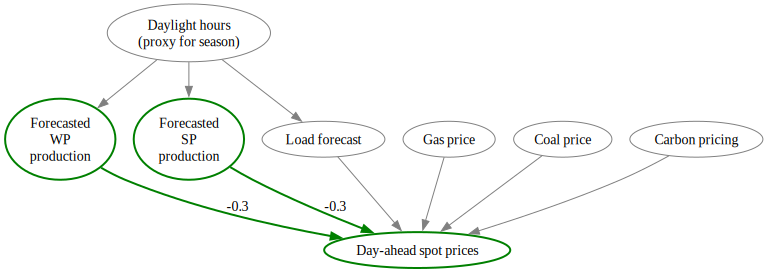

In [1]:
import graphviz
from IPython.display import display

# Create a new graph
dot = graphviz.Digraph()

# Add nodes
dot.node('S', 'Daylight hours \n(proxy for season)', color='gray')
dot.node('WP', 'Forecasted \nWP \nproduction', penwidth='2', color='green')
dot.node('SP', 'Forecasted \nSP \nproduction', penwidth='2', color='green')
dot.node('L', 'Load forecast', color='gray')
dot.node('G', 'Gas price', color='gray')
dot.node('C', 'Coal price', color='gray')
dot.node('CO2', 'Carbon pricing', color='gray')
dot.node('P', 'Day-ahead spot prices', penwidth='2', color='green')

# Define coefficients for the edges
coefficients = {
    ('S', 'L'): '',
    ('S', 'WP'): '',
    ('S', 'SP'): '',
    ('WP', 'P'): '-0.3',
    ('SP', 'P'): '-0.3',
    ('L', 'P'): '',
    ('G', 'P'): '',
    ('CO2', 'P'): '',
    ('C', 'P'): ''
}

# Add edges with coefficients as labels and make only WP->P and SP->P green
for (start, end), coeff in coefficients.items():
    edge_color = 'green' if (start, end) in [('WP', 'P'), ('SP', 'P')] else 'gray'
    dot.edge(start, end, label=coeff, color=edge_color, penwidth='2' if (start, end) in [('WP', 'P'), ('SP', 'P')] else '1')


# Display the graph in the notebook
display(dot)

We can now create a simple **simulator** for this kind of data, and plot the results of a simulation run, to show the data:

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


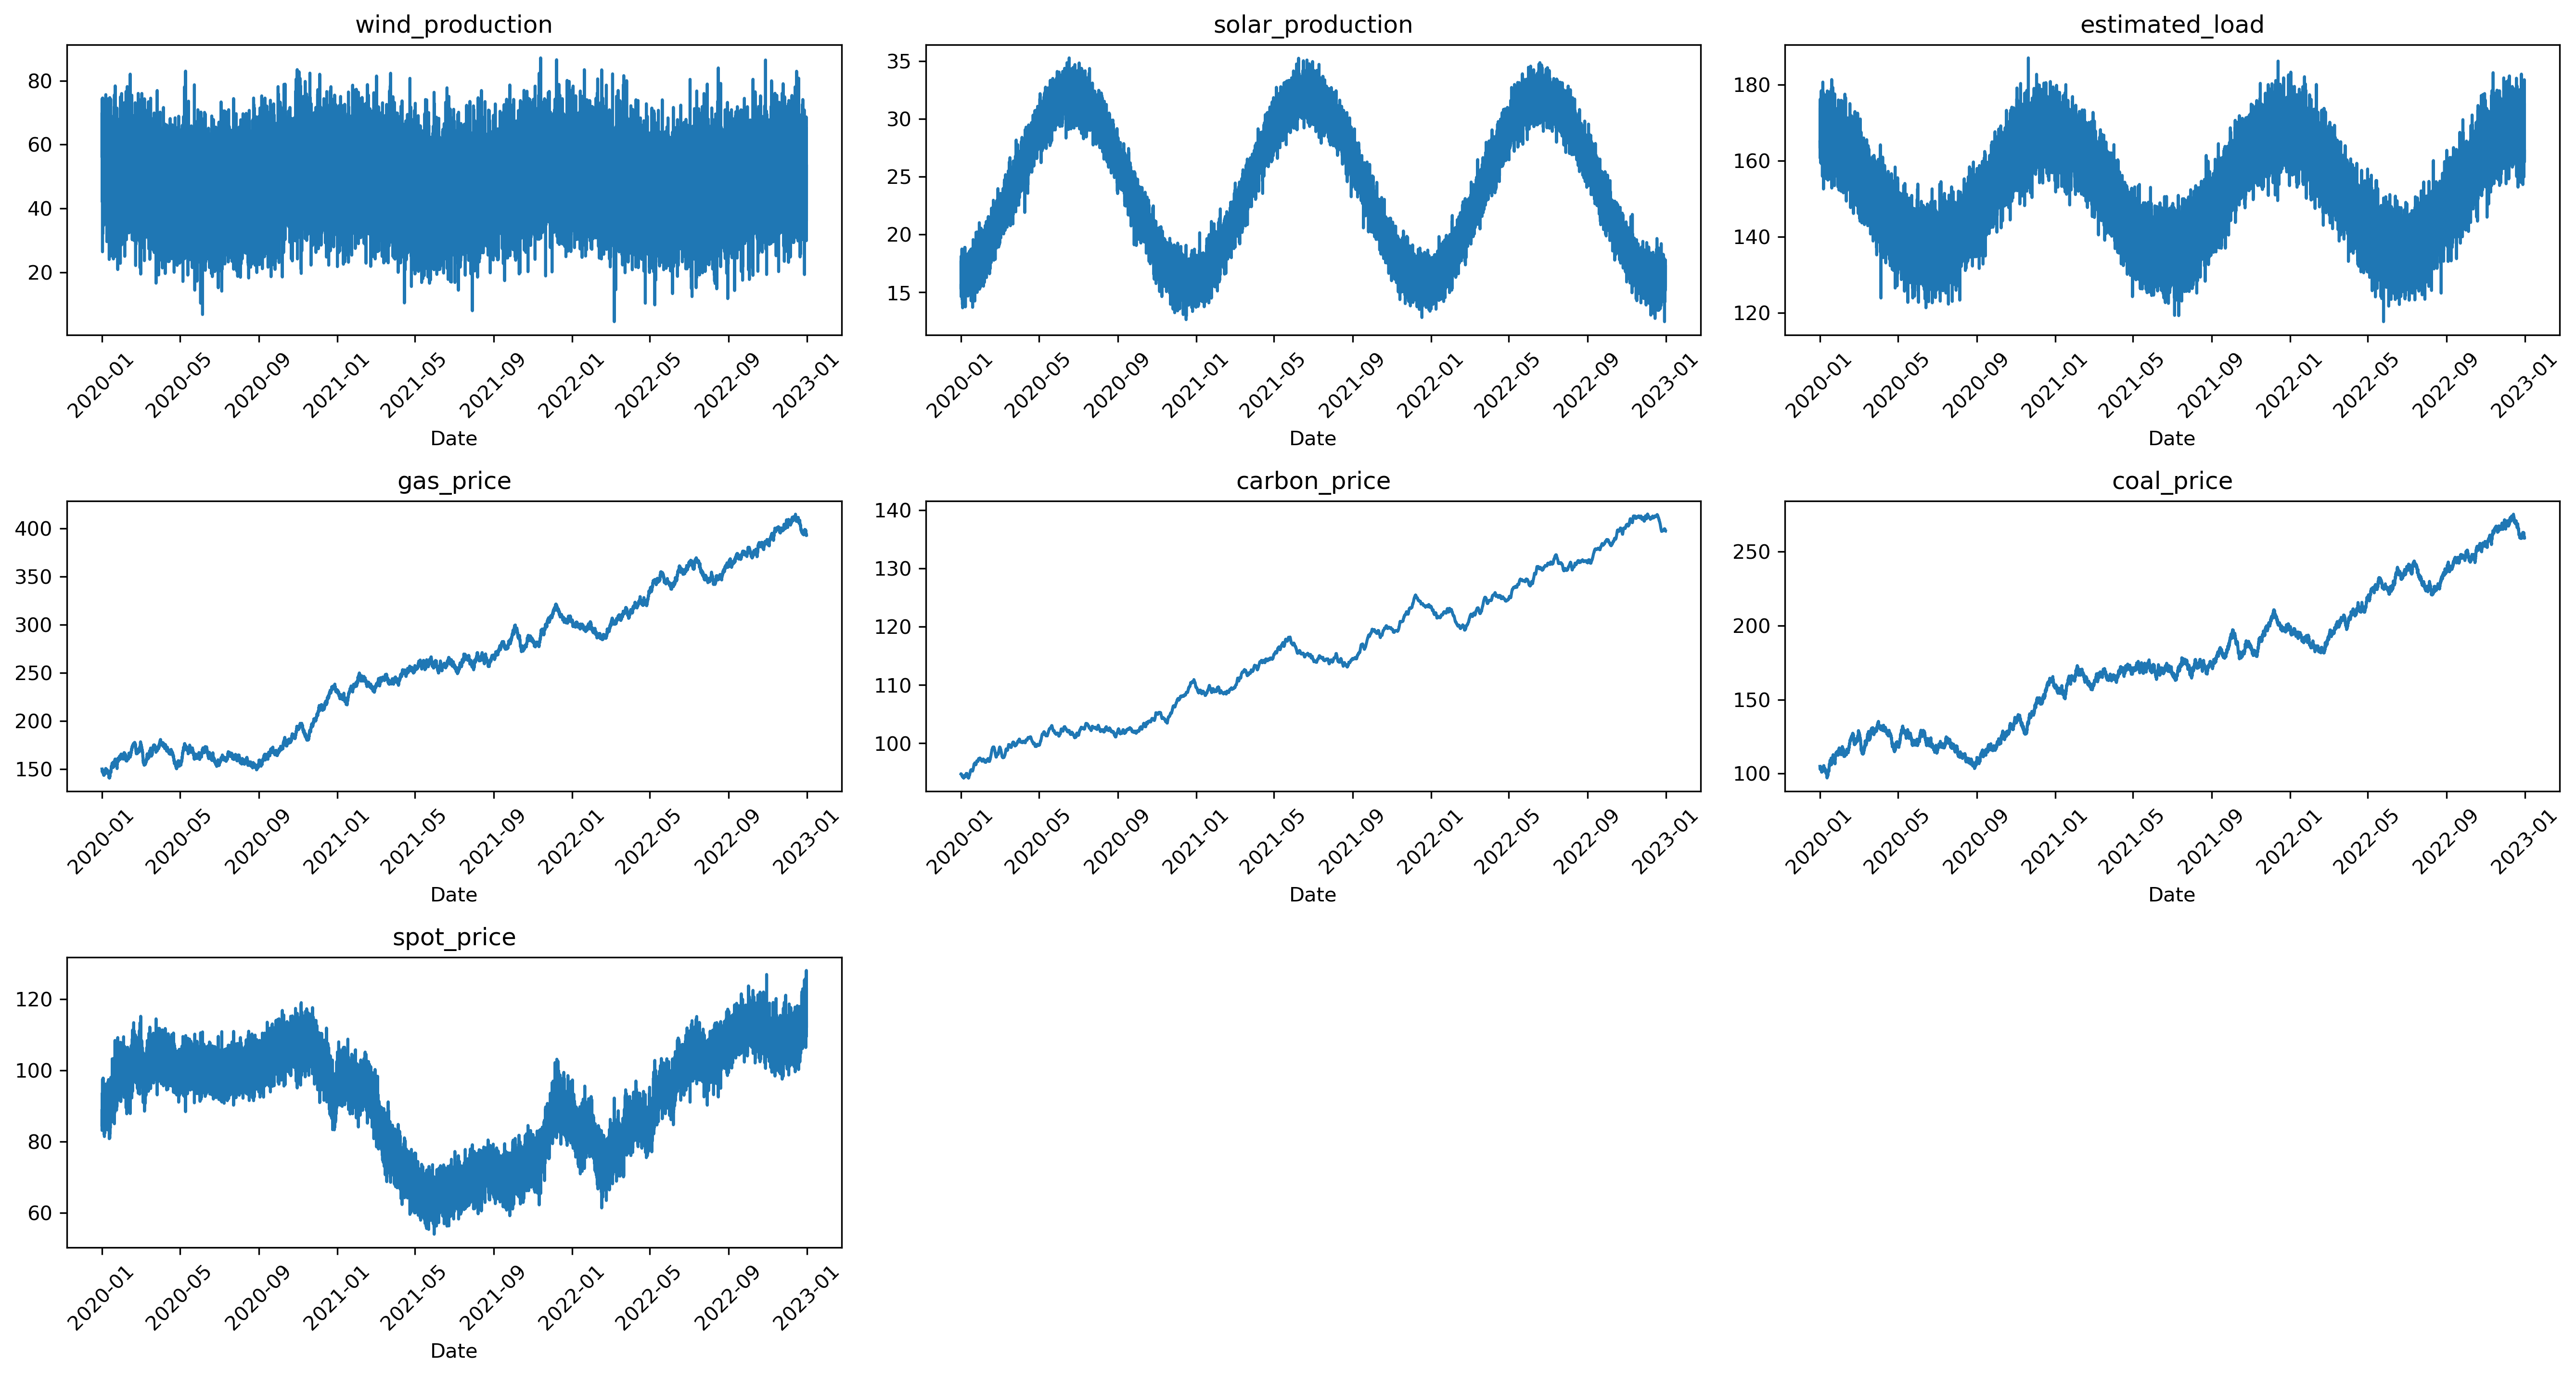

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, s, f
from sklearn.model_selection import KFold
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

def generate_data(n_years=1, random_seed=None, plot_time_series=False):
    if random_seed is not None:
        np.random.seed(random_seed)

    hours_per_day = 24
    days_per_year = 365
    n = hours_per_day * days_per_year * n_years

    date_range = pd.date_range(start='2020-01-01', periods=n, freq='h')
    time = np.arange(n)
    day_of_year = (time // hours_per_day) % days_per_year
    D = 8 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / days_per_year) + 4

    WP = 60 - 1 * D + np.random.normal(0, 10, n)
    SP = 2 * D + np.random.normal(0, 1, n)
    L = 200 - 4 * D + np.random.normal(0, 5, n)
    G = 150 + np.cumsum(np.random.normal(0, 0.5, n))
    G = np.maximum(G, 50) + np.random.normal(0, 0.01, n)
    C = 80 + 0.1 * G + 0.05 * np.cumsum(np.random.normal(0, 1, n))
    C = gaussian_filter(np.maximum(C, 40), sigma=10) + np.random.normal(0, 0.01, n)
    O = 0.7 * G + 0.1 * np.cumsum(np.random.normal(0, 1, n))
    
    noiseless_P = (-0.3 * WP - 0.3 * SP  + (L**5)/10e9 +
                   -50 / (1 + np.exp(0.2 * (G - 100))) + 20 * np.sin(C/5) + 10 * np.log(O + 1))
    P = 50 + noiseless_P + np.random.normal(0, .1, n)

    data = pd.DataFrame({
        'daylight_hours': D,
        'wind_production': WP,
        'solar_production': SP,
        'estimated_load': L,
        'gas_price': G,
        'carbon_price': C,
        'coal_price': O,
        'spot_price': P
    }, index=date_range)

    if plot_time_series:
        plt.figure(figsize=(18, 12), dpi=300)
        for i, var in enumerate(data.columns[1:], 1):
            plt.subplot(4, 3, i)
            plt.plot(data[var])
            plt.title(var)
            plt.xlabel('Date')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return data

data = generate_data(n_years=3, random_seed=0, plot_time_series=True)

We can see that the simulator simply tries to emulate the seasonality in load and renewables production, with higher demands in colder months and higher SP production during summer months.

### The DML Algorithm

We can now implement the DML framework we have seen before, where we try to remove the effect of confounders by fitting a nonlinear model, in this case an generalized additive model (GAM) on the confounders. Here, we are in a peculiar DML setting, where the confounders affecting the treatment variables and the response variable are not the same. Indeed, we have:
- Confounder for the treatments: daylight hours.
- Confounders for the response: daylight hours, estimated load, gas price, coal price, carbon pricing.

Here is the code for implementing DML:

In [3]:
def dml_algorithm(data, n_splits=5, n_repeats=1, seed=42):
    results = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for _ in range(n_repeats):
        fold_coefs = []
        for train_index, test_index in kf.split(data):
            train, test = data.iloc[train_index], data.iloc[test_index]

            confounders = ['gas_price', 'coal_price', 'carbon_price', 'estimated_load', 'daylight_hours']

            # Residualize using GAM
            gam_wp = LinearGAM(s(0)).fit(train[['daylight_hours']], train['wind_production'])
            gam_sp = LinearGAM(s(0)).fit(train[['daylight_hours']], train['solar_production'])
            gam_spot_price = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4)).fit(train[confounders], train['spot_price'])

            test_wp_residuals = test['wind_production'] - gam_wp.predict(test[['daylight_hours']])
            test_sp_residuals = test['solar_production'] - gam_sp.predict(test[['daylight_hours']])
            test_spot_price_residuals = test['spot_price'] - gam_spot_price.predict(test[confounders])

            # Step 4: Regress residuals
            model = LinearRegression().fit(np.vstack([test_wp_residuals, test_sp_residuals]).T, test_spot_price_residuals)
            fold_coefs.append(model.coef_)

        results.append(np.mean(fold_coefs, axis=0))

    return np.median(results, axis=0)

This algorithm implements the DML approach to estimate the causal effects of wind and solar production on spot prices, while controlling for confounding variables. The DML framework helps to reduce bias and improve the robustness of causal inference by using machine learning models in a cross-validation setup.

The main steps of the algorithm are:
1. **Initialisation:** set up the cross-validation scheme with a specified number of splits and repetitions to ensure robust estimation.

2. **Data splitting:** split the dataset into training and testing subsets multiple times using k-fold cross-validation. This helps in obtaining reliable estimates by averaging results over different data partitions.

3. **Confounder selection:** identify and use relevant confounding variables that may affect the outcome (spot prices) to control for their influence.

4. **Residualisation:** fit machine learning models (in this case, GAMs) to predict the variables of interest (wind production, solar production, and spot prices) based on the confounders. Then, compute the residuals, which are the differences between the observed values and the predicted values from the models. These residuals represent the portion of the variation in the variables that is not explained by the confounders.

5. **Second-stage regression:** perform a second-stage regression using the residuals from the first step. Specifically, regress the residuals of wind and solar production against the residuals of spot prices to estimate the causal effects.

6. **Aggregation of results:** aggregate the coefficients obtained from the second-stage regression across all folds and repetitions. Typically, this involves taking the mean or median of the coefficients to provide a final estimate of the causal effects.

In summary, we leverage the DML framework to disentangle the causal effects of wind and solar production on spot prices by controlling for confounders. We use cross-validation and machine learning models to ensure robust and unbiased estimation of these effects.

To have a **benchmark**, we also compare the DML method with two simpler approaches:
1. Two features: a simple approach where we fit a linear regression model only on the two treatment variables
2. ALl the features: an all-inclusive approach where we fit a linear regression model on all the available features.

In [4]:
def fit_models(data):
    results = {}

    # Method (i) Using only WP and SP as predictors
    X_wp_sp = data[['wind_production', 'solar_production']]
    y = data['spot_price']
    model_wp_sp = LinearRegression().fit(X_wp_sp, y)
    results['wp_sp']  = model_wp_sp.coef_
    
    # Method (ii) Using all variables as predictors
    X_all = data.drop(columns=['spot_price'])
    model_all = LinearRegression().fit(X_all, y)
    
    # Extracting coefficients for wind_production and solar_production specifically
    coef_all = model_all.coef_
    wp_idx = list(X_all.columns).index('wind_production')
    sp_idx = list(X_all.columns).index('solar_production')
    results['all'] = np.array([coef_all[wp_idx], coef_all[sp_idx]])
    
    return results

Let's now run replicate the data generation and parameter estimation experiment using the three approaches (DML and the two benchmarks):

In [5]:
n_iterations = 5
coefficients = {
    'wp_sp': [],
    'all': [],
    'DML': []
}

# Loop to generate data, residualize covariates, and fit models
for i in range(n_iterations):
    df = generate_data(n_years=3, random_seed=i)
    # df_residualized = residualize_data(df)
    df_residualized = df.copy()
    res1 = fit_models(df)
    res2 = dml_algorithm(df_residualized, seed=i)

    for key in res1:
        coefficients[key].append(res1[key])
    coefficients['DML'].append(res2)

# Convert to DataFrame for analysis
coefficients_df = {key: np.array(value) for key, value in coefficients.items()}
coefficients_df = pd.DataFrame({
    'Two features_wp': coefficients_df['wp_sp'][:, 0],
    'Two features_sp': coefficients_df['wp_sp'][:, 1],
    'All the features_wp': coefficients_df['all'][:, 0],
    'All the features_sp': coefficients_df['all'][:, 1],
    'DML_wp': coefficients_df['DML'][:, 0],
    'DML_sp': coefficients_df['DML'][:, 1]
})

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Let's now plot the results:

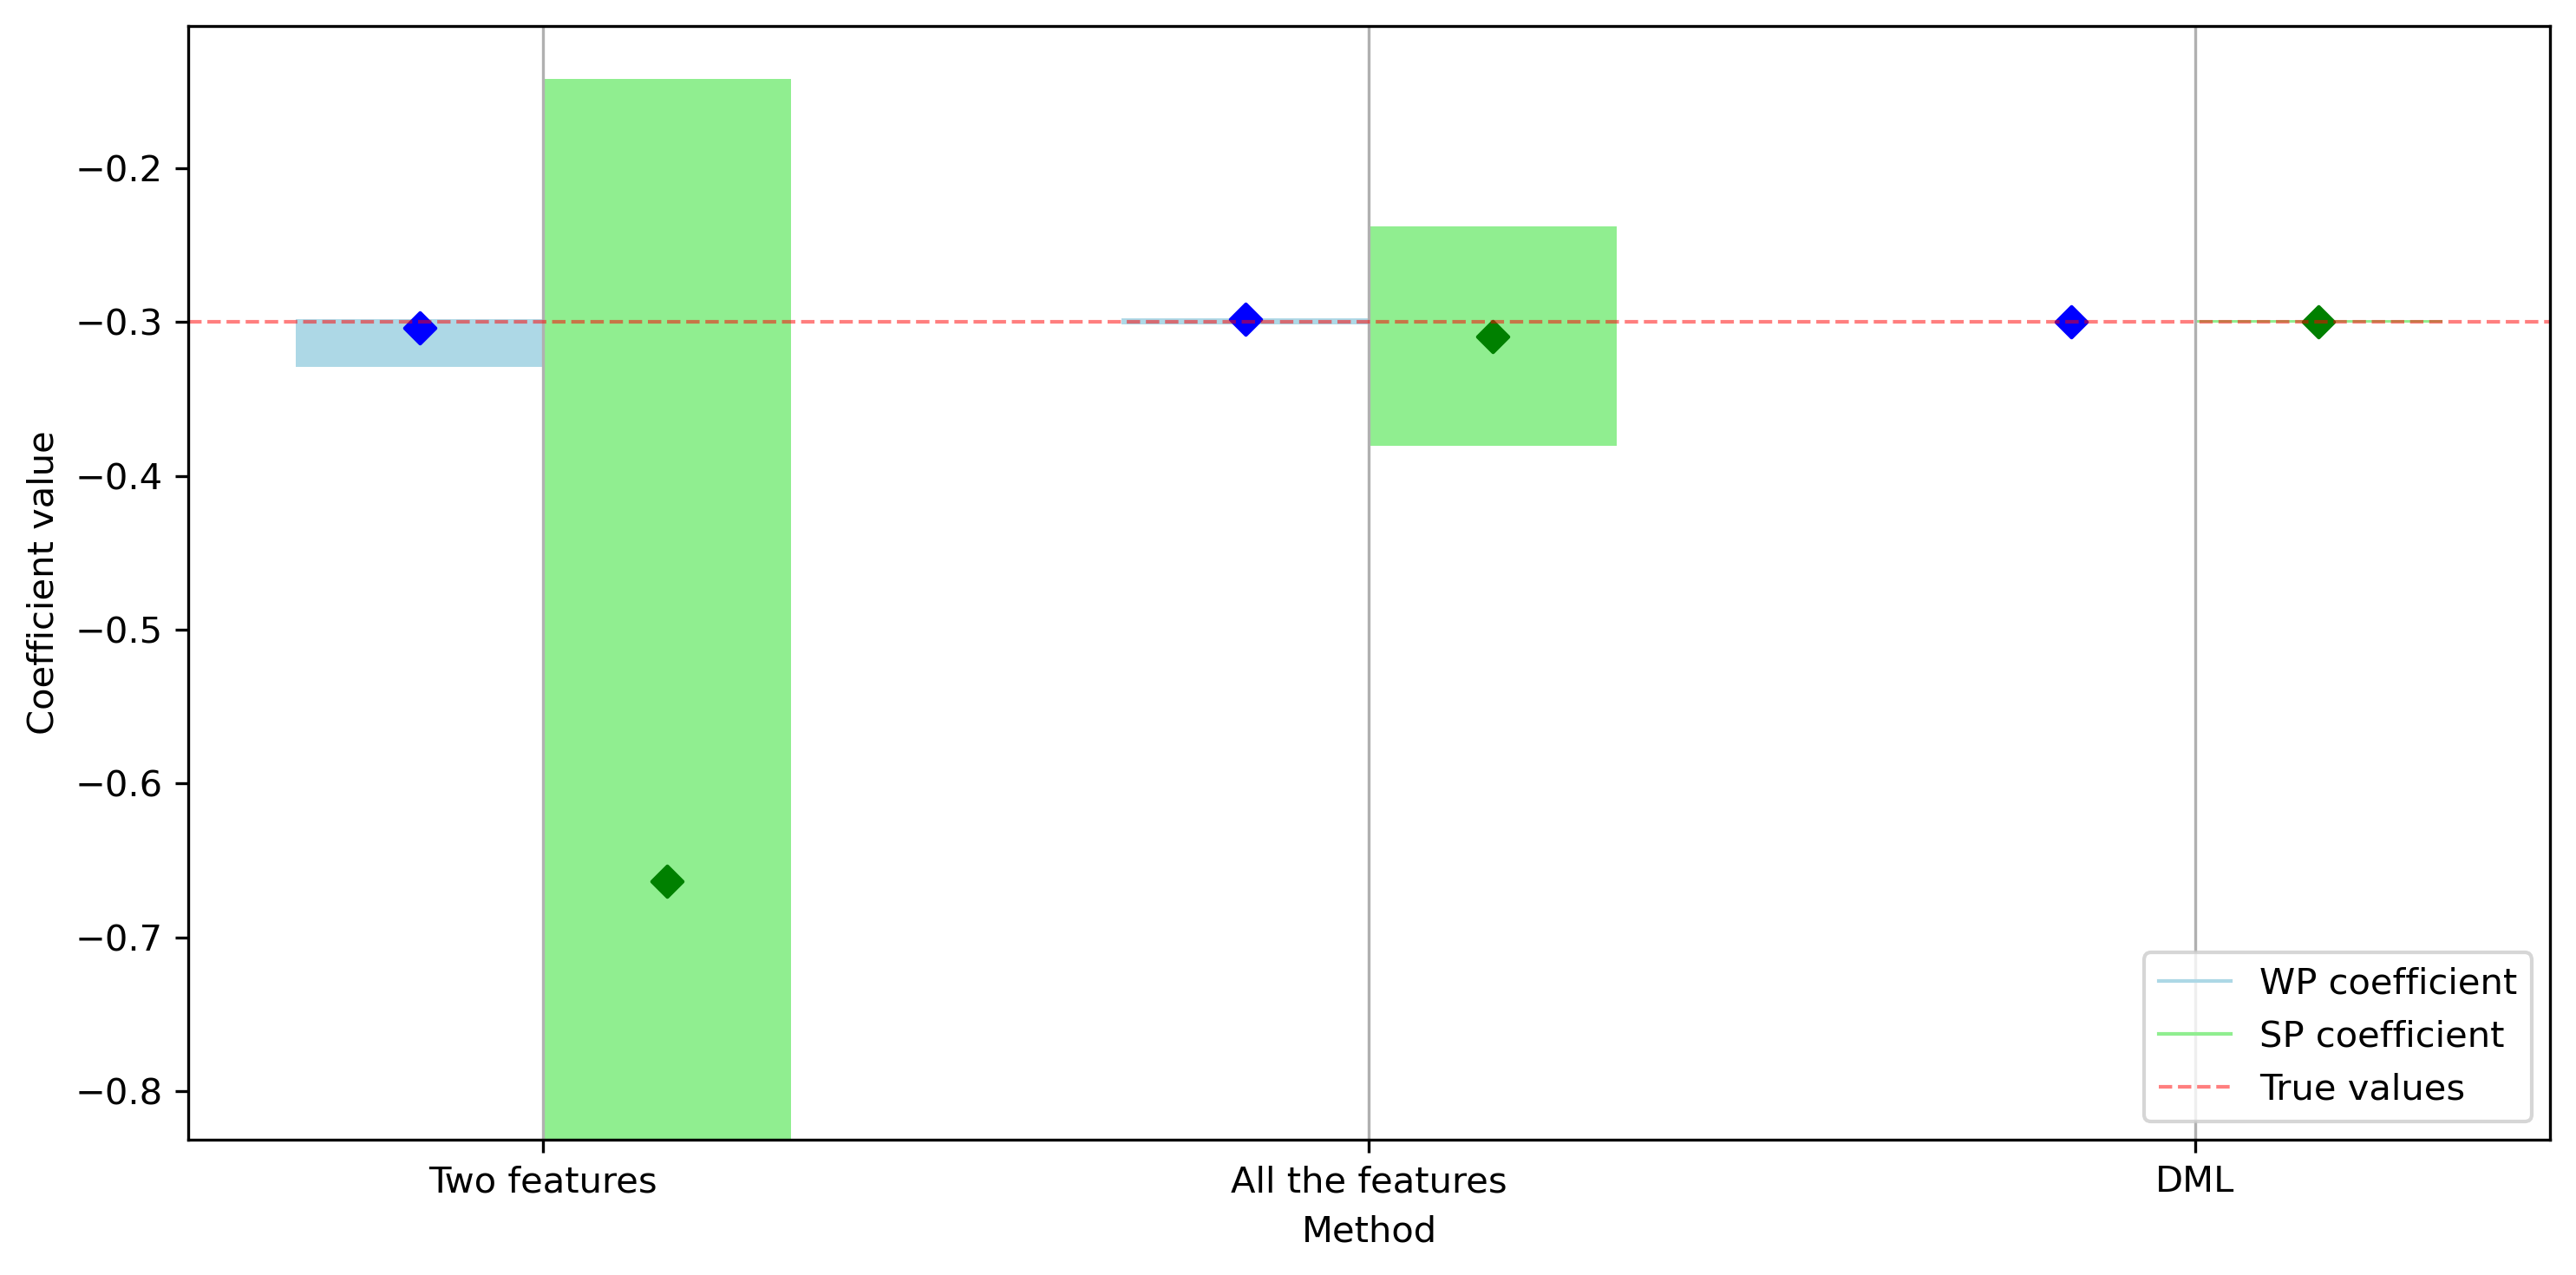

In [6]:
# Define the labels and colors
labels = ['Two features', 'All the features', 'DML']
colors = ['lightblue', 'lightgreen']
markers = ['blue', 'green']

# Calculate new quantiles (P10, P50, P90)
quantiles = coefficients_df.quantile([0.10, 0.5, 0.90]).T
quantiles.columns = ['P10', 'P50', 'P90']
quantiles = quantiles.reset_index().rename(columns={'index': 'Coefficient'})

# Plot the quantiles
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

bar_width = 0.3
bins = np.arange(len(labels))

for i, label in enumerate(labels):
    wp_label = f'{label}_wp'
    sp_label = f'{label}_sp'
    wp_data = quantiles[quantiles['Coefficient'] == wp_label]
    sp_data = quantiles[quantiles['Coefficient'] == sp_label]
    offset_wp = i - bar_width / 2
    offset_sp = i + bar_width / 2
    
    # WP bars and points
    ax.bar(offset_wp, wp_data['P90'].values - wp_data['P10'].values, bottom=wp_data['P10'].values, width=bar_width, color='lightblue', label='WP coefficient' if i == 0 else "")
    ax.scatter(offset_wp, wp_data['P50'].values, color='blue', marker='D')
    
    # SP bars and points
    ax.bar(offset_sp, sp_data['P90'].values - sp_data['P10'].values, bottom=sp_data['P10'].values, width=bar_width, color='lightgreen', label='SP coefficient' if i == 0 else "")
    ax.scatter(offset_sp, sp_data['P50'].values, color='green', marker='D')

# Set x-axis labels
ax.set_xticks(bins)
ax.set_xticklabels(labels)

# Simplified legend
handles = [
    plt.Line2D([0], [0], color='lightblue', lw=1, label='WP coefficient'),
    plt.Line2D([0], [0], color='lightgreen', lw=1, label='SP coefficient'),
    plt.Line2D([0], [0], color='red', linewidth=1, alpha=0.5, ls='--', label='True values')
]

# Add horizontal line for the true value
ax.axhline(y=-0.3, color='red', linestyle='--', linewidth=1, alpha=0.5)
# ax.set_title('Quantiles of Estimated Coefficients for WP and SP')
ax.set_xlabel('Method')
ax.set_ylabel('Coefficient value')
ax.grid(axis='x')
ax.legend(handles=handles, loc='lower right')
plt.tight_layout()
plt.show()

We can see how the DML framework proves very effective in reducing the effect of the confounders on the estimation process. We can also see how the two-feature approach performs poorly, suffering from the **omitted variable bias**. Also, the all-inclusive approach, widely used in econometrics, has a much higher estimation variance. This is also due to the fact the specified model is linear while some of the effects were actually nonlinear.